In [1]:
%pip install gdown
%pip install tqdm
import gdown

url = "https://drive.google.com/drive/folders/1iYO-Kwh4RFq6mm5UNPTRO7te8T6jOA6f?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/Dataset/AlexNet.py',
 '/content/Dataset/custom_cnn.py',
 '/content/Dataset/Dataset_resized.zip']

In [2]:
import os
import zipfile
import shutil
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch


# Percorso della cartella Project_Biometric/Dataset
dataset_path = "Dataset"

# Funzione per estrarre i file zip e rimuoverli
def extract_and_remove_zip(zip_path, extract_to):
    """
    Estrae il contenuto di un file zip e poi elimina il file zip.
    Args:
        zip_path (str): percorso del file zip da estrarre.
        extract_to (str): cartella di destinazione in cui estrarre i file.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)  # Rimuove il file zip dopo l'estrazione
    print(f"File zip {zip_path} estratto e rimosso.")

# Estrai e rimuovi i file ZIP nella cartella dataset
zip_files = [f for f in os.listdir(dataset_path) if f.endswith('.zip')]
for zip_file in zip_files:
    zip_path = os.path.join(dataset_path, zip_file)
    extract_and_remove_zip(zip_path, dataset_path)

# Funzione per analizzare il nome del file
# def parse_filename(filename):
#     parts = filename.split("_")
#     object_type = parts[0]  # Nome oggetto (es. nose, mouth, eyes)
#     age = parts[1]          # Età
#     gender = parts[2]       # Sesso
#     ethnicity = parts[3]    # Etnia
#     return object_type, age, gender, ethnicity

# dataset_path = "Dataset/Dataset_resized"

# # Processa ogni sottocartella (ad esempio eyes, mouth, nose)
# for folder in os.listdir(dataset_path):
#     folder_path = os.path.join(dataset_path, folder)

#     # Procedi solo se è una directory
#     if os.path.isdir(folder_path):
#         print(f"Elaborazione della cartella: {folder}")

#         # Crea le sottocartelle train e test
#         train_folder = os.path.join(folder_path, "train")
#         test_folder = os.path.join(folder_path, "test")
#         os.makedirs(train_folder, exist_ok=True)
#         os.makedirs(test_folder, exist_ok=True)

#         # Raggruppa i file in base a età ed etnia
#         file_groups = defaultdict(list)
#         files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

#         # Raggruppa per età ed etnia
#         for file in files:
#             file_path = os.path.join(folder_path, file)
#             try:
#                 object_type, age, gender, ethnicity = parse_filename(file)
#                 if object_type and age and gender and ethnicity:
#                     file_groups[(age, ethnicity)].append(file)
#                 else:
#                     print(f"File non valido (parametri mancanti): {file}. Eliminazione...")
#                     os.remove(file_path)  # Elimina file non valido
#             except IndexError:
#                 print(f"File non conforme al formato: {file}. Eliminazione...")
#                 os.remove(file_path)  # Elimina file non conforme

#         # Suddividi i file in modo bilanciato tra train e test
#         train_files = []
#         test_files = []

#         for group, group_files in file_groups.items():
#             if len(group_files) == 1:
#                 # Se c'è solo un file, assegnalo al training set
#                 train_files.extend(group_files)
#             else:
#                 # Altrimenti, suddividi il gruppo in train e test (80% train, 20% test)
#                 train, test = train_test_split(group_files, test_size=0.2, random_state=42)
#                 train_files.extend(train)
#                 test_files.extend(test)

#         # Sposta i file nelle rispettive cartelle train e test
#         for file in train_files:
#             shutil.move(os.path.join(folder_path, file), os.path.join(train_folder, file))

#         for file in test_files:
#             shutil.move(os.path.join(folder_path, file), os.path.join(test_folder, file))

# # Comprime l'intera directory in un file zip
# zip_path = f"{dataset_path}.zip"
# print(f"Compressione della cartella principale in: {zip_path}")
# shutil.make_archive(dataset_path, 'zip', dataset_path)

print("Processo completato!")




File zip Dataset/Dataset_resized.zip estratto e rimosso.
Processo completato!


**Conteggio numero immagini per ogni set**

In [3]:
dataset_path = "Dataset"
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    # Procedi solo se è una directory
    if os.path.isdir(folder_path):
        train_folder = os.path.join(folder_path, "train")
        test_folder = os.path.join(folder_path, "test")

        train_count = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]) if os.path.exists(train_folder) else 0
        test_count = len([f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]) if os.path.exists(test_folder) else 0

        print(f"Cartella '{folder}':")
        print(f"  Train set: {train_count} file")
        print(f"  Test set: {test_count} file")

Cartella 'mouth':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'nose':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'eyes':
  Train set: 18255 file
  Test set: 4776 file


In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
# Impostare la trasformazione
transform_eyes = transforms.Compose([
    transforms.Resize((44, 266)),  # Cambia dimensione a (altezza, larghezza)
    transforms.ToTensor(),        # Converte l'immagine in tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Transform per il naso (108x170)
transform_nose = transforms.Compose([
    transforms.Resize((170, 108)),  # Cambia dimensione a (altezza, larghezza)
    transforms.ToTensor(),         # Converte l'immagine in tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Transform per la bocca (193x89)
transform_mouth = transforms.Compose([
    transforms.Resize((89, 193)),  # Cambia dimensione a (altezza, larghezza)
    transforms.ToTensor(),        # Converte l'immagine in tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Dataset personalizzato
class EthnicityDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Scansione della cartella per ottenere i file
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Considerando immagini .jpg e .png
                self.images.append(filename)

                # Estraiamo l'etnia dalla parte finale del nome del file
                # esempio: eyes_100_1_0_20170112213001988
                parts = filename.split('_')
                if len(parts) >= 4:
                    label = parts[3]  # L'etnia è il quarto elemento (indice 3)
                    label_map = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4}  # Mappatura delle etnie
                    self.labels.append(label_map.get(label, -1))  # -1 se l'etnia non è trovata

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        # Aggiungi un controllo se l'etichetta è corretta
        if label == -1:
            print(f"Errore: etichetta non trovata per {image_name}")

        return image, label

In [6]:
from Dataset.custom_cnn import CNN
from Dataset.AlexNet import AlexNet
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import seaborn as sns
import matplotlib.pyplot as plt
import math

def get_output_size(x, y):
    # Layer 1 (Conv2d + MaxPool2d)
    x1 = math.floor((x - 11) / 4) + 1  # Dopo Conv2d
    x1 = math.floor(x1 / 2)  # Dopo MaxPool2d
    y1 = math.floor((y - 11) / 4) + 1  # Dopo Conv2d
    y1 = math.floor(y1 / 2)  # Dopo MaxPool2d

    # Layer 2 (Conv2d + MaxPool2d)
    x2 = math.floor((x1 - 5 + 2 * 2) / 1) + 1  # Dopo Conv2d (kernel 5, stride 1, padding 2)
    x2 = math.floor(x2 / 2)  # Dopo MaxPool2d
    y2 = math.floor((y1 - 5 + 2 * 2) / 1) + 1  # Dopo Conv2d
    y2 = math.floor(y2 / 2)  # Dopo MaxPool2d

    # Layer 3 (Conv2d, senza pooling)
    x3 = x2  # La dimensione non cambia
    y3 = y2  # La dimensione non cambia

    # Layer 4 (Conv2d, senza pooling)
    x4 = x3  # La dimensione non cambia
    y4 = y3  # La dimensione non cambia

    # Layer 5 (Conv2d, senza MaxPool2d)
    x_out = x4
    y_out = y4

    return x_out, y_out

ex = 266
ey = 44
nx = 108
ny = 170
my = 89
mx = 193

ex, ey = get_output_size(ex, ey)
nx, ny = get_output_size(nx, ny)
mx, my = get_output_size(mx, my)

e_x = 16
e_y = 2
n_x = 6
n_y = 10
m_x = 12
m_y = 5

hid_1 = 64
hid_2 = 64
hid_3 = 128
hid_4 = 128
hid_5 = 128
hid_6 = 128
drop_1 = 0.2
drop_2 = 0.5

# eyes_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, e_x, e_y, drop_1, drop_2)
# nose_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, n_x, n_y, drop_1, drop_2)
# mouth_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, m_x, m_y, drop_1, drop_2)

eyes_net = AlexNet(ex,ey)
nose_net = AlexNet(nx,ny)
mouth_net = AlexNet(mx,my)

class_names = ["White", "Black", "Asian", "Indian", "Others"]

**EYES TRAINING VALIDATION AND TEST**

In [7]:
# Inizializzare il dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/eyes/train", transform=transform_eyes)
test_dataset = EthnicityDataset(root_dir="Dataset/eyes/test", transform=transform_eyes)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Parametri di Early Stopping
patience = 4  # Numero massimo di epoche senza miglioramenti

# K-fold Cross-Validation
k = 5  # Scegliamo K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array per salvare i risultati di ogni fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

num_epochs = 10
batch_size = 32

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Creare i subset per training e validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Creare i dataloader per il fold corrente
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinizializzare il modello e l'ottimizzatore per ogni fold
    eyes_net = eyes_net.to(device)  # Assicurarsi che il modello sia su GPU/CPU corretta
    eyes_optimizer = torch.optim.Adam(eyes_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    best_model_state = None  # Per salvare lo stato del modello
    best_val_loss = float("inf")  # Migliore loss iniziale
    no_improvement = 0  # Contatore per epoche senza miglioramenti

    # Metriche per ogni fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training per ogni fold
    for epoch in range(num_epochs):
        # Training Phase
        eyes_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            eyes_optimizer.zero_grad()

            # Forward pass
            outputs = eyes_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            eyes_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        eyes_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = eyes_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping: verifica miglioramento della loss di validazione
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
            best_val_loss = avg_val_loss
            best_model_state = eyes_net.state_dict()  # Salva il miglior modello
            no_improvement = 0  # Resetta il contatore
        else:
            no_improvement += 1
            print(f"No improvement for {no_improvement} epochs.")

        # Controlla se interrompere l'allenamento per Early Stopping
        if no_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

    # Carica il miglior modello salvato per questo fold
    eyes_net.load_state_dict(best_model_state)

    # Salvare i risultati del fold corrente
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

# Calcolare le metriche medie su tutti i fold
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 457/457 [00:35<00:00, 12.84batch/s]


Fold 1, Epoch 1, Train Loss: 1.4149, Train Accuracy: 0.4655


Validating Fold 1, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 27.98batch/s]


Fold 1, Epoch 1, Val Loss: 1.3300, Val Accuracy: 0.4996
Validation loss improved from inf to 1.3300. Saving model...


Training Fold 1, Epoch 2: 100%|██████████| 457/457 [00:27<00:00, 16.67batch/s]


Fold 1, Epoch 2, Train Loss: 1.2449, Train Accuracy: 0.5267


Validating Fold 1, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 35.12batch/s]


Fold 1, Epoch 2, Val Loss: 1.1721, Val Accuracy: 0.5336
Validation loss improved from 1.3300 to 1.1721. Saving model...


Training Fold 1, Epoch 3: 100%|██████████| 457/457 [00:27<00:00, 16.63batch/s]


Fold 1, Epoch 3, Train Loss: 1.1587, Train Accuracy: 0.5648


Validating Fold 1, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 34.18batch/s]


Fold 1, Epoch 3, Val Loss: 1.0796, Val Accuracy: 0.6023
Validation loss improved from 1.1721 to 1.0796. Saving model...


Training Fold 1, Epoch 4: 100%|██████████| 457/457 [00:29<00:00, 15.59batch/s]


Fold 1, Epoch 4, Train Loss: 1.0877, Train Accuracy: 0.5959


Validating Fold 1, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 34.98batch/s]


Fold 1, Epoch 4, Val Loss: 0.9750, Val Accuracy: 0.6434
Validation loss improved from 1.0796 to 0.9750. Saving model...


Training Fold 1, Epoch 5: 100%|██████████| 457/457 [00:27<00:00, 16.65batch/s]


Fold 1, Epoch 5, Train Loss: 1.0309, Train Accuracy: 0.6286


Validating Fold 1, Epoch 5: 100%|██████████| 115/115 [00:03<00:00, 35.12batch/s]


Fold 1, Epoch 5, Val Loss: 0.9852, Val Accuracy: 0.6464
No improvement for 1 epochs.


Training Fold 1, Epoch 6: 100%|██████████| 457/457 [00:27<00:00, 16.41batch/s]


Fold 1, Epoch 6, Train Loss: 0.9729, Train Accuracy: 0.6515


Validating Fold 1, Epoch 6: 100%|██████████| 115/115 [00:03<00:00, 31.42batch/s]


Fold 1, Epoch 6, Val Loss: 0.9664, Val Accuracy: 0.6472
Validation loss improved from 0.9750 to 0.9664. Saving model...


Training Fold 1, Epoch 7: 100%|██████████| 457/457 [00:27<00:00, 16.62batch/s]


Fold 1, Epoch 7, Train Loss: 0.9312, Train Accuracy: 0.6695


Validating Fold 1, Epoch 7: 100%|██████████| 115/115 [00:03<00:00, 34.07batch/s]


Fold 1, Epoch 7, Val Loss: 0.9258, Val Accuracy: 0.6658
Validation loss improved from 0.9664 to 0.9258. Saving model...


Training Fold 1, Epoch 8: 100%|██████████| 457/457 [00:28<00:00, 16.02batch/s]


Fold 1, Epoch 8, Train Loss: 0.9069, Train Accuracy: 0.6788


Validating Fold 1, Epoch 8: 100%|██████████| 115/115 [00:04<00:00, 26.20batch/s]


Fold 1, Epoch 8, Val Loss: 0.9532, Val Accuracy: 0.6721
No improvement for 1 epochs.


Training Fold 1, Epoch 9: 100%|██████████| 457/457 [00:27<00:00, 16.40batch/s]


Fold 1, Epoch 9, Train Loss: 0.8661, Train Accuracy: 0.6942


Validating Fold 1, Epoch 9: 100%|██████████| 115/115 [00:03<00:00, 33.87batch/s]


Fold 1, Epoch 9, Val Loss: 0.8557, Val Accuracy: 0.6952
Validation loss improved from 0.9258 to 0.8557. Saving model...


Training Fold 1, Epoch 10: 100%|██████████| 457/457 [00:27<00:00, 16.48batch/s]


Fold 1, Epoch 10, Train Loss: 0.8314, Train Accuracy: 0.7051


Validating Fold 1, Epoch 10: 100%|██████████| 115/115 [00:03<00:00, 29.01batch/s]


Fold 1, Epoch 10, Val Loss: 0.8701, Val Accuracy: 0.6864
No improvement for 1 epochs.
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 457/457 [00:27<00:00, 16.48batch/s]


Fold 2, Epoch 1, Train Loss: 0.8278, Train Accuracy: 0.7104


Validating Fold 2, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 34.84batch/s]


Fold 2, Epoch 1, Val Loss: 0.7554, Val Accuracy: 0.7291
Validation loss improved from inf to 0.7554. Saving model...


Training Fold 2, Epoch 2: 100%|██████████| 457/457 [00:27<00:00, 16.53batch/s]


Fold 2, Epoch 2, Train Loss: 0.7944, Train Accuracy: 0.7190


Validating Fold 2, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 33.98batch/s]


Fold 2, Epoch 2, Val Loss: 0.7585, Val Accuracy: 0.7253
No improvement for 1 epochs.


Training Fold 2, Epoch 3: 100%|██████████| 457/457 [00:27<00:00, 16.36batch/s]


Fold 2, Epoch 3, Train Loss: 0.7599, Train Accuracy: 0.7320


Validating Fold 2, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 34.03batch/s]


Fold 2, Epoch 3, Val Loss: 0.7433, Val Accuracy: 0.7365
Validation loss improved from 0.7554 to 0.7433. Saving model...


Training Fold 2, Epoch 4: 100%|██████████| 457/457 [00:27<00:00, 16.47batch/s]


Fold 2, Epoch 4, Train Loss: 0.7318, Train Accuracy: 0.7442


Validating Fold 2, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 35.15batch/s]


Fold 2, Epoch 4, Val Loss: 0.8083, Val Accuracy: 0.7198
No improvement for 1 epochs.


Training Fold 2, Epoch 5: 100%|██████████| 457/457 [00:27<00:00, 16.46batch/s]


Fold 2, Epoch 5, Train Loss: 0.6975, Train Accuracy: 0.7559


Validating Fold 2, Epoch 5: 100%|██████████| 115/115 [00:03<00:00, 29.04batch/s]


Fold 2, Epoch 5, Val Loss: 0.8198, Val Accuracy: 0.7198
No improvement for 2 epochs.


Training Fold 2, Epoch 6: 100%|██████████| 457/457 [00:27<00:00, 16.53batch/s]


Fold 2, Epoch 6, Train Loss: 0.6636, Train Accuracy: 0.7674


Validating Fold 2, Epoch 6: 100%|██████████| 115/115 [00:03<00:00, 35.26batch/s]


Fold 2, Epoch 6, Val Loss: 0.7383, Val Accuracy: 0.7390
Validation loss improved from 0.7433 to 0.7383. Saving model...


Training Fold 2, Epoch 7: 100%|██████████| 457/457 [00:27<00:00, 16.61batch/s]


Fold 2, Epoch 7, Train Loss: 0.6251, Train Accuracy: 0.7816


Validating Fold 2, Epoch 7: 100%|██████████| 115/115 [00:03<00:00, 29.92batch/s]


Fold 2, Epoch 7, Val Loss: 0.7279, Val Accuracy: 0.7425
Validation loss improved from 0.7383 to 0.7279. Saving model...


Training Fold 2, Epoch 8: 100%|██████████| 457/457 [00:27<00:00, 16.51batch/s]


Fold 2, Epoch 8, Train Loss: 0.5890, Train Accuracy: 0.7964


Validating Fold 2, Epoch 8: 100%|██████████| 115/115 [00:03<00:00, 34.60batch/s]


Fold 2, Epoch 8, Val Loss: 0.7898, Val Accuracy: 0.7310
No improvement for 1 epochs.


Training Fold 2, Epoch 9: 100%|██████████| 457/457 [00:27<00:00, 16.46batch/s]


Fold 2, Epoch 9, Train Loss: 0.5638, Train Accuracy: 0.8009


Validating Fold 2, Epoch 9: 100%|██████████| 115/115 [00:03<00:00, 31.91batch/s]


Fold 2, Epoch 9, Val Loss: 0.7870, Val Accuracy: 0.7280
No improvement for 2 epochs.


Training Fold 2, Epoch 10: 100%|██████████| 457/457 [00:27<00:00, 16.38batch/s]


Fold 2, Epoch 10, Train Loss: 0.5184, Train Accuracy: 0.8177


Validating Fold 2, Epoch 10: 100%|██████████| 115/115 [00:03<00:00, 34.77batch/s]


Fold 2, Epoch 10, Val Loss: 0.8293, Val Accuracy: 0.7319
No improvement for 3 epochs.
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 457/457 [00:27<00:00, 16.46batch/s]


Fold 3, Epoch 1, Train Loss: 0.5899, Train Accuracy: 0.7973


Validating Fold 3, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 35.27batch/s]


Fold 3, Epoch 1, Val Loss: 0.5362, Val Accuracy: 0.8107
Validation loss improved from inf to 0.5362. Saving model...


Training Fold 3, Epoch 2: 100%|██████████| 457/457 [00:27<00:00, 16.43batch/s]


Fold 3, Epoch 2, Train Loss: 0.5385, Train Accuracy: 0.8127


Validating Fold 3, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 30.00batch/s]


Fold 3, Epoch 2, Val Loss: 0.5079, Val Accuracy: 0.8266
Validation loss improved from 0.5362 to 0.5079. Saving model...


Training Fold 3, Epoch 3: 100%|██████████| 457/457 [00:27<00:00, 16.43batch/s]


Fold 3, Epoch 3, Train Loss: 0.4982, Train Accuracy: 0.8256


Validating Fold 3, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 34.35batch/s]


Fold 3, Epoch 3, Val Loss: 0.5359, Val Accuracy: 0.8091
No improvement for 1 epochs.


Training Fold 3, Epoch 4: 100%|██████████| 457/457 [00:27<00:00, 16.40batch/s]


Fold 3, Epoch 4, Train Loss: 0.4661, Train Accuracy: 0.8350


Validating Fold 3, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 27.62batch/s]


Fold 3, Epoch 4, Val Loss: 0.5473, Val Accuracy: 0.8094
No improvement for 2 epochs.


Training Fold 3, Epoch 5: 100%|██████████| 457/457 [00:27<00:00, 16.56batch/s]


Fold 3, Epoch 5, Train Loss: 0.4333, Train Accuracy: 0.8492


Validating Fold 3, Epoch 5: 100%|██████████| 115/115 [00:03<00:00, 35.23batch/s]


Fold 3, Epoch 5, Val Loss: 0.5433, Val Accuracy: 0.8157
No improvement for 3 epochs.


Training Fold 3, Epoch 6: 100%|██████████| 457/457 [00:27<00:00, 16.48batch/s]


Fold 3, Epoch 6, Train Loss: 0.3988, Train Accuracy: 0.8616


Validating Fold 3, Epoch 6: 100%|██████████| 115/115 [00:03<00:00, 30.04batch/s]


Fold 3, Epoch 6, Val Loss: 0.6609, Val Accuracy: 0.7844
No improvement for 4 epochs.
Early stopping triggered at epoch 6.
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 457/457 [00:27<00:00, 16.40batch/s]


Fold 4, Epoch 1, Train Loss: 0.4580, Train Accuracy: 0.8417


Validating Fold 4, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 34.99batch/s]


Fold 4, Epoch 1, Val Loss: 0.3092, Val Accuracy: 0.8915
Validation loss improved from inf to 0.3092. Saving model...


Training Fold 4, Epoch 2: 100%|██████████| 457/457 [00:27<00:00, 16.59batch/s]


Fold 4, Epoch 2, Train Loss: 0.3951, Train Accuracy: 0.8626


Validating Fold 4, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 34.98batch/s]


Fold 4, Epoch 2, Val Loss: 0.3027, Val Accuracy: 0.8935
Validation loss improved from 0.3092 to 0.3027. Saving model...


Training Fold 4, Epoch 3: 100%|██████████| 457/457 [00:27<00:00, 16.36batch/s]


Fold 4, Epoch 3, Train Loss: 0.3672, Train Accuracy: 0.8725


Validating Fold 4, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 31.56batch/s]


Fold 4, Epoch 3, Val Loss: 0.3561, Val Accuracy: 0.8729
No improvement for 1 epochs.


Training Fold 4, Epoch 4: 100%|██████████| 457/457 [00:27<00:00, 16.54batch/s]


Fold 4, Epoch 4, Train Loss: 0.3381, Train Accuracy: 0.8863


Validating Fold 4, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 35.07batch/s]


Fold 4, Epoch 4, Val Loss: 0.4038, Val Accuracy: 0.8543
No improvement for 2 epochs.


Training Fold 4, Epoch 5: 100%|██████████| 457/457 [00:27<00:00, 16.55batch/s]


Fold 4, Epoch 5, Train Loss: 0.3150, Train Accuracy: 0.8922


Validating Fold 4, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 28.36batch/s]


Fold 4, Epoch 5, Val Loss: 0.3941, Val Accuracy: 0.8620
No improvement for 3 epochs.


Training Fold 4, Epoch 6: 100%|██████████| 457/457 [00:27<00:00, 16.51batch/s]


Fold 4, Epoch 6, Train Loss: 0.2839, Train Accuracy: 0.9032


Validating Fold 4, Epoch 6: 100%|██████████| 115/115 [00:03<00:00, 34.82batch/s]


Fold 4, Epoch 6, Val Loss: 0.4459, Val Accuracy: 0.8431
No improvement for 4 epochs.
Early stopping triggered at epoch 6.
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 457/457 [00:27<00:00, 16.48batch/s]


Fold 5, Epoch 1, Train Loss: 0.3446, Train Accuracy: 0.8822


Validating Fold 5, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 30.47batch/s]


Fold 5, Epoch 1, Val Loss: 0.2266, Val Accuracy: 0.9310
Validation loss improved from inf to 0.2266. Saving model...


Training Fold 5, Epoch 2: 100%|██████████| 457/457 [00:27<00:00, 16.38batch/s]


Fold 5, Epoch 2, Train Loss: 0.2917, Train Accuracy: 0.9002


Validating Fold 5, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 34.15batch/s]


Fold 5, Epoch 2, Val Loss: 0.2244, Val Accuracy: 0.9176
Validation loss improved from 0.2266 to 0.2244. Saving model...


Training Fold 5, Epoch 3: 100%|██████████| 457/457 [00:27<00:00, 16.50batch/s]


Fold 5, Epoch 3, Train Loss: 0.2737, Train Accuracy: 0.9055


Validating Fold 5, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 33.33batch/s]


Fold 5, Epoch 3, Val Loss: 0.2612, Val Accuracy: 0.9093
No improvement for 1 epochs.


Training Fold 5, Epoch 4: 100%|██████████| 457/457 [00:27<00:00, 16.34batch/s]


Fold 5, Epoch 4, Train Loss: 0.2409, Train Accuracy: 0.9169


Validating Fold 5, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 34.44batch/s]


Fold 5, Epoch 4, Val Loss: 0.2811, Val Accuracy: 0.9014
No improvement for 2 epochs.


Training Fold 5, Epoch 5: 100%|██████████| 457/457 [00:27<00:00, 16.41batch/s]


Fold 5, Epoch 5, Train Loss: 0.2323, Train Accuracy: 0.9219


Validating Fold 5, Epoch 5: 100%|██████████| 115/115 [00:03<00:00, 34.93batch/s]


Fold 5, Epoch 5, Val Loss: 0.3430, Val Accuracy: 0.8806
No improvement for 3 epochs.


Training Fold 5, Epoch 6: 100%|██████████| 457/457 [00:27<00:00, 16.33batch/s]


Fold 5, Epoch 6, Train Loss: 0.2217, Train Accuracy: 0.9259


Validating Fold 5, Epoch 6: 100%|██████████| 115/115 [00:03<00:00, 29.23batch/s]

Fold 5, Epoch 6, Val Loss: 0.3840, Val Accuracy: 0.8762
No improvement for 4 epochs.
Early stopping triggered at epoch 6.
Average Training Loss: 0.5672
Average Validation Loss: 0.5995
Average Training Accuracy: 0.7992
Average Validation Accuracy: 0.7882


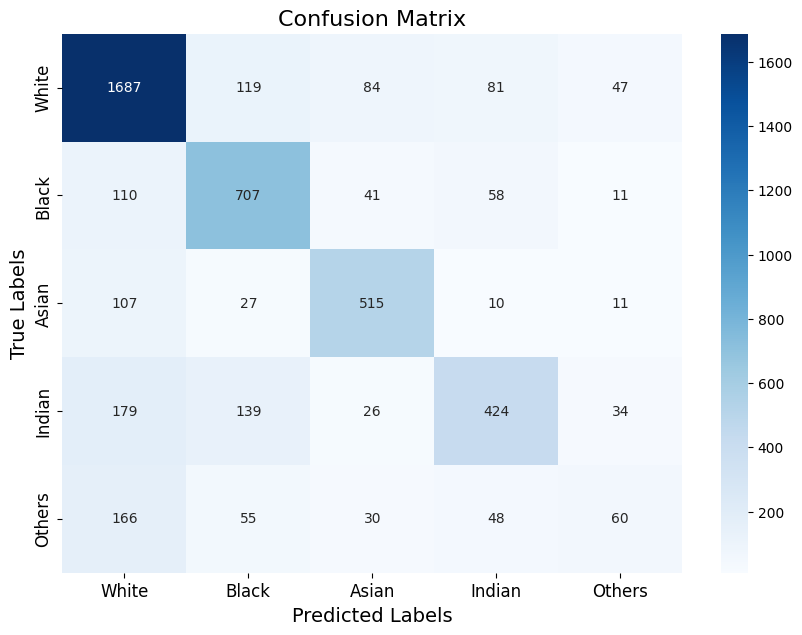


Classification Report:
              precision    recall  f1-score   support

       White       0.75      0.84      0.79      2018
       Black       0.68      0.76      0.72       927
       Asian       0.74      0.77      0.75       670
      Indian       0.68      0.53      0.60       802
      Others       0.37      0.17      0.23       359

    accuracy                           0.71      4776
   macro avg       0.64      0.61      0.62      4776
weighted avg       0.69      0.71      0.70      4776



In [8]:

all_labels = []  # Per memorizzare le etichette reali
all_preds = []   # Per memorizzare le previsioni del modello

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = eyes_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


# Calcola le metriche
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Aggiungi titoli e etichette agli assi
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra la heatmap
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**NOSE TRAINING VALIDATION AND TEST**

In [9]:
# Inizializzare il dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/nose/train", transform=transform_nose)
test_dataset = EthnicityDataset(root_dir="Dataset/nose/test", transform=transform_nose)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Parametri di Early Stopping
patience = 4  # Numero massimo di epoche senza miglioramenti


# K-fold Cross-Validation
k = 5  # Numero di fold per la K-Fold Cross Validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array per salvare i risultati di ogni fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

num_epochs = 10
batch_size = 32

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Creare i subset per training e validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Creare i dataloader per il fold corrente
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinizializzare il modello e l'ottimizzatore per ogni fold
    nose_net = nose_net.to(device)  # Assicurarsi che il modello sia su GPU/CPU corretta
    nose_optimizer = torch.optim.Adam(nose_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    best_model_state = None  # Per salvare lo stato del modello
    best_val_loss = float("inf")  # Migliore loss iniziale
    no_improvement = 0  # Contatore per epoche senza miglioramenti

    # Metriche per ogni fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training per ogni fold
    for epoch in range(num_epochs):
        # Training Phase
        nose_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            nose_optimizer.zero_grad()

            # Forward pass
            outputs = nose_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nose_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        nose_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = nose_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping: verifica miglioramento della loss di validazione
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
            best_val_loss = avg_val_loss
            best_model_state = nose_net.state_dict()  # Salva il miglior modello
            no_improvement = 0  # Resetta il contatore
        else:
            no_improvement += 1
            print(f"No improvement for {no_improvement} epochs.")

        # Controlla se interrompere l'allenamento per Early Stopping
        if no_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

    # Carica il miglior modello salvato per questo fold
    nose_net.load_state_dict(best_model_state)

    # Salvare i risultati del fold corrente
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

# Calcolare le metriche medie su tutti i fold
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 457/457 [00:39<00:00, 11.51batch/s]


Fold 1, Epoch 1, Train Loss: 1.5347, Train Accuracy: 0.4406


Validating Fold 1, Epoch 1: 100%|██████████| 115/115 [00:05<00:00, 22.73batch/s]


Fold 1, Epoch 1, Val Loss: 1.3768, Val Accuracy: 0.4703
Validation loss improved from inf to 1.3768. Saving model...


Training Fold 1, Epoch 2: 100%|██████████| 457/457 [00:39<00:00, 11.62batch/s]


Fold 1, Epoch 2, Train Loss: 1.3683, Train Accuracy: 0.4725


Validating Fold 1, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 26.16batch/s]


Fold 1, Epoch 2, Val Loss: 1.3253, Val Accuracy: 0.5053
Validation loss improved from 1.3768 to 1.3253. Saving model...


Training Fold 1, Epoch 3: 100%|██████████| 457/457 [00:39<00:00, 11.59batch/s]


Fold 1, Epoch 3, Train Loss: 1.3248, Train Accuracy: 0.4912


Validating Fold 1, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 24.25batch/s]


Fold 1, Epoch 3, Val Loss: 1.3009, Val Accuracy: 0.5242
Validation loss improved from 1.3253 to 1.3009. Saving model...


Training Fold 1, Epoch 4: 100%|██████████| 457/457 [00:39<00:00, 11.60batch/s]


Fold 1, Epoch 4, Train Loss: 1.2925, Train Accuracy: 0.5014


Validating Fold 1, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 25.95batch/s]


Fold 1, Epoch 4, Val Loss: 1.2694, Val Accuracy: 0.5248
Validation loss improved from 1.3009 to 1.2694. Saving model...


Training Fold 1, Epoch 5: 100%|██████████| 457/457 [00:39<00:00, 11.62batch/s]


Fold 1, Epoch 5, Train Loss: 1.2670, Train Accuracy: 0.5161


Validating Fold 1, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 27.18batch/s]


Fold 1, Epoch 5, Val Loss: 1.2402, Val Accuracy: 0.5346
Validation loss improved from 1.2694 to 1.2402. Saving model...


Training Fold 1, Epoch 6: 100%|██████████| 457/457 [00:39<00:00, 11.69batch/s]


Fold 1, Epoch 6, Train Loss: 1.2382, Train Accuracy: 0.5253


Validating Fold 1, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 23.10batch/s]


Fold 1, Epoch 6, Val Loss: 1.2216, Val Accuracy: 0.5467
Validation loss improved from 1.2402 to 1.2216. Saving model...


Training Fold 1, Epoch 7: 100%|██████████| 457/457 [00:39<00:00, 11.71batch/s]


Fold 1, Epoch 7, Train Loss: 1.2162, Train Accuracy: 0.5353


Validating Fold 1, Epoch 7: 100%|██████████| 115/115 [00:04<00:00, 26.42batch/s]


Fold 1, Epoch 7, Val Loss: 1.1986, Val Accuracy: 0.5514
Validation loss improved from 1.2216 to 1.1986. Saving model...


Training Fold 1, Epoch 8: 100%|██████████| 457/457 [00:38<00:00, 11.75batch/s]


Fold 1, Epoch 8, Train Loss: 1.1743, Train Accuracy: 0.5584


Validating Fold 1, Epoch 8: 100%|██████████| 115/115 [00:04<00:00, 23.88batch/s]


Fold 1, Epoch 8, Val Loss: 1.1718, Val Accuracy: 0.5582
Validation loss improved from 1.1986 to 1.1718. Saving model...


Training Fold 1, Epoch 9: 100%|██████████| 457/457 [00:39<00:00, 11.59batch/s]


Fold 1, Epoch 9, Train Loss: 1.1263, Train Accuracy: 0.5767


Validating Fold 1, Epoch 9: 100%|██████████| 115/115 [00:04<00:00, 26.51batch/s]


Fold 1, Epoch 9, Val Loss: 1.1082, Val Accuracy: 0.5897
Validation loss improved from 1.1718 to 1.1082. Saving model...


Training Fold 1, Epoch 10: 100%|██████████| 457/457 [00:39<00:00, 11.59batch/s]


Fold 1, Epoch 10, Train Loss: 1.0905, Train Accuracy: 0.5935


Validating Fold 1, Epoch 10: 100%|██████████| 115/115 [00:04<00:00, 25.79batch/s]


Fold 1, Epoch 10, Val Loss: 1.0709, Val Accuracy: 0.5957
Validation loss improved from 1.1082 to 1.0709. Saving model...
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 457/457 [00:38<00:00, 11.75batch/s]


Fold 2, Epoch 1, Train Loss: 1.0784, Train Accuracy: 0.6027


Validating Fold 2, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 25.42batch/s]


Fold 2, Epoch 1, Val Loss: 1.0593, Val Accuracy: 0.6149
Validation loss improved from inf to 1.0593. Saving model...


Training Fold 2, Epoch 2: 100%|██████████| 457/457 [00:38<00:00, 11.79batch/s]


Fold 2, Epoch 2, Train Loss: 1.0350, Train Accuracy: 0.6235


Validating Fold 2, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 27.65batch/s]


Fold 2, Epoch 2, Val Loss: 1.0215, Val Accuracy: 0.6324
Validation loss improved from 1.0593 to 1.0215. Saving model...


Training Fold 2, Epoch 3: 100%|██████████| 457/457 [00:38<00:00, 11.80batch/s]


Fold 2, Epoch 3, Train Loss: 1.0146, Train Accuracy: 0.6285


Validating Fold 2, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 23.79batch/s]


Fold 2, Epoch 3, Val Loss: 1.0476, Val Accuracy: 0.6168
No improvement for 1 epochs.


Training Fold 2, Epoch 4: 100%|██████████| 457/457 [00:38<00:00, 11.78batch/s]


Fold 2, Epoch 4, Train Loss: 0.9762, Train Accuracy: 0.6469


Validating Fold 2, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 27.01batch/s]


Fold 2, Epoch 4, Val Loss: 0.9878, Val Accuracy: 0.6341
Validation loss improved from 1.0215 to 0.9878. Saving model...


Training Fold 2, Epoch 5: 100%|██████████| 457/457 [00:38<00:00, 11.82batch/s]


Fold 2, Epoch 5, Train Loss: 0.9622, Train Accuracy: 0.6512


Validating Fold 2, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 27.45batch/s]


Fold 2, Epoch 5, Val Loss: 0.9882, Val Accuracy: 0.6437
No improvement for 1 epochs.


Training Fold 2, Epoch 6: 100%|██████████| 457/457 [00:39<00:00, 11.71batch/s]


Fold 2, Epoch 6, Train Loss: 0.9376, Train Accuracy: 0.6608


Validating Fold 2, Epoch 6: 100%|██████████| 115/115 [00:05<00:00, 22.90batch/s]


Fold 2, Epoch 6, Val Loss: 1.0135, Val Accuracy: 0.6335
No improvement for 2 epochs.


Training Fold 2, Epoch 7: 100%|██████████| 457/457 [00:39<00:00, 11.69batch/s]


Fold 2, Epoch 7, Train Loss: 0.9105, Train Accuracy: 0.6728


Validating Fold 2, Epoch 7: 100%|██████████| 115/115 [00:04<00:00, 26.79batch/s]


Fold 2, Epoch 7, Val Loss: 0.9870, Val Accuracy: 0.6396
Validation loss improved from 0.9878 to 0.9870. Saving model...


Training Fold 2, Epoch 8: 100%|██████████| 457/457 [00:38<00:00, 11.75batch/s]


Fold 2, Epoch 8, Train Loss: 0.8840, Train Accuracy: 0.6805


Validating Fold 2, Epoch 8: 100%|██████████| 115/115 [00:04<00:00, 25.28batch/s]


Fold 2, Epoch 8, Val Loss: 0.9708, Val Accuracy: 0.6426
Validation loss improved from 0.9870 to 0.9708. Saving model...


Training Fold 2, Epoch 9: 100%|██████████| 457/457 [00:38<00:00, 11.76batch/s]


Fold 2, Epoch 9, Train Loss: 0.8720, Train Accuracy: 0.6854


Validating Fold 2, Epoch 9: 100%|██████████| 115/115 [00:04<00:00, 25.12batch/s]


Fold 2, Epoch 9, Val Loss: 0.9493, Val Accuracy: 0.6574
Validation loss improved from 0.9708 to 0.9493. Saving model...


Training Fold 2, Epoch 10: 100%|██████████| 457/457 [00:39<00:00, 11.70batch/s]


Fold 2, Epoch 10, Train Loss: 0.8371, Train Accuracy: 0.6981


Validating Fold 2, Epoch 10: 100%|██████████| 115/115 [00:04<00:00, 27.05batch/s]


Fold 2, Epoch 10, Val Loss: 0.9225, Val Accuracy: 0.6667
Validation loss improved from 0.9493 to 0.9225. Saving model...
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 457/457 [00:38<00:00, 11.80batch/s]


Fold 3, Epoch 1, Train Loss: 0.8663, Train Accuracy: 0.6900


Validating Fold 3, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 23.31batch/s]


Fold 3, Epoch 1, Val Loss: 0.7739, Val Accuracy: 0.7286
Validation loss improved from inf to 0.7739. Saving model...


Training Fold 3, Epoch 2: 100%|██████████| 457/457 [00:38<00:00, 11.79batch/s]


Fold 3, Epoch 2, Train Loss: 0.8355, Train Accuracy: 0.7025


Validating Fold 3, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 27.15batch/s]


Fold 3, Epoch 2, Val Loss: 0.7966, Val Accuracy: 0.7184
No improvement for 1 epochs.


Training Fold 3, Epoch 3: 100%|██████████| 457/457 [00:38<00:00, 11.80batch/s]


Fold 3, Epoch 3, Train Loss: 0.7955, Train Accuracy: 0.7149


Validating Fold 3, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 27.32batch/s]


Fold 3, Epoch 3, Val Loss: 0.8233, Val Accuracy: 0.7034
No improvement for 2 epochs.


Training Fold 3, Epoch 4: 100%|██████████| 457/457 [00:38<00:00, 11.80batch/s]


Fold 3, Epoch 4, Train Loss: 0.7725, Train Accuracy: 0.7247


Validating Fold 3, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 24.03batch/s]


Fold 3, Epoch 4, Val Loss: 0.8349, Val Accuracy: 0.6995
No improvement for 3 epochs.


Training Fold 3, Epoch 5: 100%|██████████| 457/457 [00:38<00:00, 11.87batch/s]


Fold 3, Epoch 5, Train Loss: 0.7420, Train Accuracy: 0.7308


Validating Fold 3, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 26.80batch/s]


Fold 3, Epoch 5, Val Loss: 0.8194, Val Accuracy: 0.7091
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 457/457 [00:38<00:00, 11.82batch/s]


Fold 4, Epoch 1, Train Loss: 0.7762, Train Accuracy: 0.7239


Validating Fold 4, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 25.55batch/s]


Fold 4, Epoch 1, Val Loss: 0.6747, Val Accuracy: 0.7636
Validation loss improved from inf to 0.6747. Saving model...


Training Fold 4, Epoch 2: 100%|██████████| 457/457 [00:38<00:00, 11.83batch/s]


Fold 4, Epoch 2, Train Loss: 0.7415, Train Accuracy: 0.7383


Validating Fold 4, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 26.49batch/s]


Fold 4, Epoch 2, Val Loss: 0.6693, Val Accuracy: 0.7642
Validation loss improved from 0.6747 to 0.6693. Saving model...


Training Fold 4, Epoch 3: 100%|██████████| 457/457 [00:38<00:00, 11.83batch/s]


Fold 4, Epoch 3, Train Loss: 0.7002, Train Accuracy: 0.7501


Validating Fold 4, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 27.11batch/s]


Fold 4, Epoch 3, Val Loss: 0.7103, Val Accuracy: 0.7458
No improvement for 1 epochs.


Training Fold 4, Epoch 4: 100%|██████████| 457/457 [00:38<00:00, 11.80batch/s]


Fold 4, Epoch 4, Train Loss: 0.6681, Train Accuracy: 0.7608


Validating Fold 4, Epoch 4: 100%|██████████| 115/115 [00:05<00:00, 22.86batch/s]


Fold 4, Epoch 4, Val Loss: 0.7187, Val Accuracy: 0.7387
No improvement for 2 epochs.


Training Fold 4, Epoch 5: 100%|██████████| 457/457 [00:38<00:00, 11.83batch/s]


Fold 4, Epoch 5, Train Loss: 0.6432, Train Accuracy: 0.7711


Validating Fold 4, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 28.08batch/s]


Fold 4, Epoch 5, Val Loss: 0.7490, Val Accuracy: 0.7401
No improvement for 3 epochs.


Training Fold 4, Epoch 6: 100%|██████████| 457/457 [00:38<00:00, 11.81batch/s]


Fold 4, Epoch 6, Train Loss: 0.6118, Train Accuracy: 0.7792


Validating Fold 4, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 26.97batch/s]


Fold 4, Epoch 6, Val Loss: 0.7356, Val Accuracy: 0.7357
No improvement for 4 epochs.
Early stopping triggered at epoch 6.
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 457/457 [00:38<00:00, 11.76batch/s]


Fold 5, Epoch 1, Train Loss: 0.6784, Train Accuracy: 0.7586


Validating Fold 5, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 24.18batch/s]


Fold 5, Epoch 1, Val Loss: 0.5464, Val Accuracy: 0.8009
Validation loss improved from inf to 0.5464. Saving model...


Training Fold 5, Epoch 2: 100%|██████████| 457/457 [00:38<00:00, 11.77batch/s]


Fold 5, Epoch 2, Train Loss: 0.6250, Train Accuracy: 0.7763


Validating Fold 5, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 27.16batch/s]


Fold 5, Epoch 2, Val Loss: 0.5559, Val Accuracy: 0.8017
No improvement for 1 epochs.


Training Fold 5, Epoch 3: 100%|██████████| 457/457 [00:38<00:00, 11.83batch/s]


Fold 5, Epoch 3, Train Loss: 0.5980, Train Accuracy: 0.7864


Validating Fold 5, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 23.33batch/s]


Fold 5, Epoch 3, Val Loss: 0.5819, Val Accuracy: 0.7943
No improvement for 2 epochs.


Training Fold 5, Epoch 4: 100%|██████████| 457/457 [00:38<00:00, 11.82batch/s]


Fold 5, Epoch 4, Train Loss: 0.5619, Train Accuracy: 0.7983


Validating Fold 5, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 27.40batch/s]


Fold 5, Epoch 4, Val Loss: 0.6062, Val Accuracy: 0.7855
No improvement for 3 epochs.


Training Fold 5, Epoch 5: 100%|██████████| 457/457 [00:38<00:00, 11.79batch/s]


Fold 5, Epoch 5, Train Loss: 0.5387, Train Accuracy: 0.8091


Validating Fold 5, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 27.22batch/s]

Fold 5, Epoch 5, Val Loss: 0.6005, Val Accuracy: 0.7943
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Average Training Loss: 0.8614
Average Validation Loss: 0.8641
Average Training Accuracy: 0.6857
Average Validation Accuracy: 0.6867


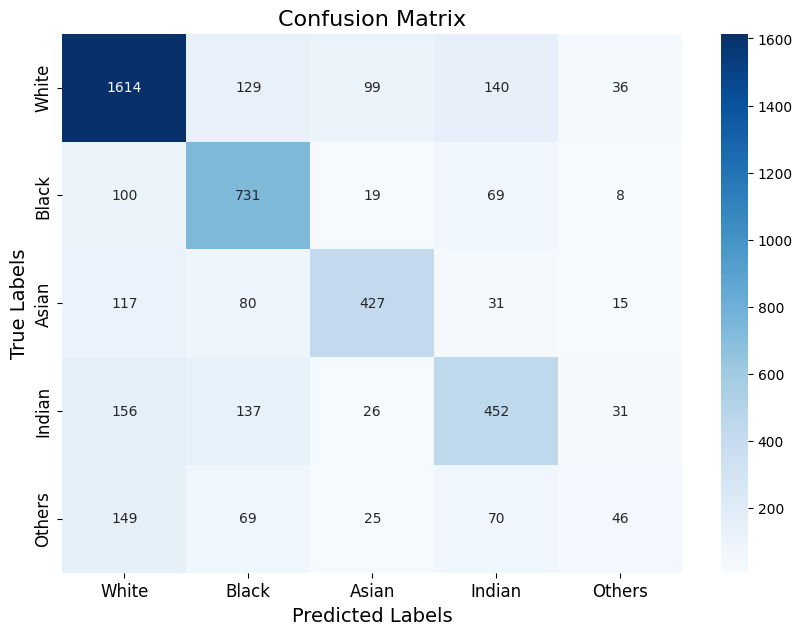


Classification Report:
              precision    recall  f1-score   support

       White       0.76      0.80      0.78      2018
       Black       0.64      0.79      0.71       927
       Asian       0.72      0.64      0.67       670
      Indian       0.59      0.56      0.58       802
      Others       0.34      0.13      0.19       359

    accuracy                           0.68      4776
   macro avg       0.61      0.58      0.58      4776
weighted avg       0.67      0.68      0.67      4776



In [10]:
all_labels = []
all_preds = []

with torch.no_grad():  # Disabilita il calcolo dei gradienti
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)


        # Forward pass
        outputs = nose_net(images)

        # Calcola le predizioni
        _, predicted = torch.max(outputs.data, 1)

        # Salva le etichette e le predizioni
        all_labels.extend(labels.cpu().numpy())        # Porta le etichette sulla CPU prima di salvarle
        all_preds.extend(predicted.cpu().numpy())


# Calcola le metriche
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Aggiungi titoli e etichette agli assi
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra la heatmap
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**MOUTH TRAINING VALIDATION AND TEST**

In [11]:
# Inizializzare il dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/mouth/train", transform=transform_mouth)
test_dataset = EthnicityDataset(root_dir="Dataset/mouth/test", transform=transform_mouth)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Parametri di Early Stopping
patience = 4  # Numero massimo di epoche senza miglioramenti

# K-fold Cross-Validation
k = 5  # Scegliamo K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array per salvare i risultati di ogni fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

num_epochs = 10
batch_size = 32

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Creare i subset per training e validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Creare i dataloader per il fold corrente
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinizializzare il modello e l'ottimizzatore per ogni fold
    mouth_net = mouth_net.to(device)  # Assicurarsi che il modello sia su GPU/CPU corretta
    mouth_optimizer = torch.optim.Adam(mouth_net.parameters(), lr=0.001, weight_decay=0.001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    best_model_state = None  # Per salvare lo stato del modello
    best_val_loss = float("inf")  # Migliore loss iniziale
    no_improvement = 0  # Contatore per epoche senza miglioramenti

    # Metriche per ogni fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training per ogni fold
    for epoch in range(num_epochs):
        # Training Phase
        mouth_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            mouth_optimizer.zero_grad()

            # Forward pass
            outputs = mouth_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            mouth_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        mouth_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = mouth_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping: verifica miglioramento della loss di validazione
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
            best_val_loss = avg_val_loss
            best_model_state = mouth_net.state_dict()  # Salva il miglior modello
            no_improvement = 0  # Resetta il contatore
        else:
            no_improvement += 1
            print(f"No improvement for {no_improvement} epochs.")

        # Controlla se interrompere l'allenamento per Early Stopping
        if no_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

    # Carica il miglior modello salvato per questo fold
    mouth_net.load_state_dict(best_model_state)

    # Salvare i risultati del fold corrente
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

# Calcolare le metriche medie su tutti i fold
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 457/457 [00:37<00:00, 12.03batch/s]


Fold 1, Epoch 1, Train Loss: 1.4296, Train Accuracy: 0.4891


Validating Fold 1, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 27.56batch/s]


Fold 1, Epoch 1, Val Loss: 1.2688, Val Accuracy: 0.5262
Validation loss improved from inf to 1.2688. Saving model...


Training Fold 1, Epoch 2: 100%|██████████| 457/457 [00:37<00:00, 12.09batch/s]


Fold 1, Epoch 2, Train Loss: 1.2687, Train Accuracy: 0.5249


Validating Fold 1, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 27.27batch/s]


Fold 1, Epoch 2, Val Loss: 1.2401, Val Accuracy: 0.5330
Validation loss improved from 1.2688 to 1.2401. Saving model...


Training Fold 1, Epoch 3: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 1, Epoch 3, Train Loss: 1.2533, Train Accuracy: 0.5358


Validating Fold 1, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 23.23batch/s]


Fold 1, Epoch 3, Val Loss: 1.2305, Val Accuracy: 0.5451
Validation loss improved from 1.2401 to 1.2305. Saving model...


Training Fold 1, Epoch 4: 100%|██████████| 457/457 [00:37<00:00, 12.03batch/s]


Fold 1, Epoch 4, Train Loss: 1.2345, Train Accuracy: 0.5381


Validating Fold 1, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 28.16batch/s]


Fold 1, Epoch 4, Val Loss: 1.1973, Val Accuracy: 0.5552
Validation loss improved from 1.2305 to 1.1973. Saving model...


Training Fold 1, Epoch 5: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 1, Epoch 5, Train Loss: 1.2143, Train Accuracy: 0.5433


Validating Fold 1, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 28.32batch/s]


Fold 1, Epoch 5, Val Loss: 1.1813, Val Accuracy: 0.5440
Validation loss improved from 1.1973 to 1.1813. Saving model...


Training Fold 1, Epoch 6: 100%|██████████| 457/457 [00:37<00:00, 12.09batch/s]


Fold 1, Epoch 6, Train Loss: 1.1838, Train Accuracy: 0.5549


Validating Fold 1, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 23.43batch/s]


Fold 1, Epoch 6, Val Loss: 1.1587, Val Accuracy: 0.5615
Validation loss improved from 1.1813 to 1.1587. Saving model...


Training Fold 1, Epoch 7: 100%|██████████| 457/457 [00:37<00:00, 12.06batch/s]


Fold 1, Epoch 7, Train Loss: 1.1578, Train Accuracy: 0.5642


Validating Fold 1, Epoch 7: 100%|██████████| 115/115 [00:04<00:00, 27.78batch/s]


Fold 1, Epoch 7, Val Loss: 1.1643, Val Accuracy: 0.5500
No improvement for 1 epochs.


Training Fold 1, Epoch 8: 100%|██████████| 457/457 [00:37<00:00, 12.10batch/s]


Fold 1, Epoch 8, Train Loss: 1.1267, Train Accuracy: 0.5751


Validating Fold 1, Epoch 8: 100%|██████████| 115/115 [00:04<00:00, 27.09batch/s]


Fold 1, Epoch 8, Val Loss: 1.1266, Val Accuracy: 0.5867
Validation loss improved from 1.1587 to 1.1266. Saving model...


Training Fold 1, Epoch 9: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 1, Epoch 9, Train Loss: 1.1076, Train Accuracy: 0.5828


Validating Fold 1, Epoch 9: 100%|██████████| 115/115 [00:04<00:00, 24.38batch/s]


Fold 1, Epoch 9, Val Loss: 1.0643, Val Accuracy: 0.5987
Validation loss improved from 1.1266 to 1.0643. Saving model...


Training Fold 1, Epoch 10: 100%|██████████| 457/457 [00:37<00:00, 12.12batch/s]


Fold 1, Epoch 10, Train Loss: 1.0838, Train Accuracy: 0.5955


Validating Fold 1, Epoch 10: 100%|██████████| 115/115 [00:04<00:00, 27.05batch/s]


Fold 1, Epoch 10, Val Loss: 1.1441, Val Accuracy: 0.5735
No improvement for 1 epochs.
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 457/457 [00:37<00:00, 12.11batch/s]


Fold 2, Epoch 1, Train Loss: 1.0654, Train Accuracy: 0.6022


Validating Fold 2, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 27.79batch/s]


Fold 2, Epoch 1, Val Loss: 1.0725, Val Accuracy: 0.6067
Validation loss improved from inf to 1.0725. Saving model...


Training Fold 2, Epoch 2: 100%|██████████| 457/457 [00:37<00:00, 12.07batch/s]


Fold 2, Epoch 2, Train Loss: 1.0542, Train Accuracy: 0.6051


Validating Fold 2, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 27.13batch/s]


Fold 2, Epoch 2, Val Loss: 1.0748, Val Accuracy: 0.5949
No improvement for 1 epochs.


Training Fold 2, Epoch 3: 100%|██████████| 457/457 [00:37<00:00, 12.11batch/s]


Fold 2, Epoch 3, Train Loss: 1.0355, Train Accuracy: 0.6102


Validating Fold 2, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 23.31batch/s]


Fold 2, Epoch 3, Val Loss: 1.0347, Val Accuracy: 0.6100
Validation loss improved from 1.0725 to 1.0347. Saving model...


Training Fold 2, Epoch 4: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 2, Epoch 4, Train Loss: 1.0180, Train Accuracy: 0.6220


Validating Fold 2, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 27.73batch/s]


Fold 2, Epoch 4, Val Loss: 1.0312, Val Accuracy: 0.6171
Validation loss improved from 1.0347 to 1.0312. Saving model...


Training Fold 2, Epoch 5: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 2, Epoch 5, Train Loss: 1.0086, Train Accuracy: 0.6203


Validating Fold 2, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 27.72batch/s]


Fold 2, Epoch 5, Val Loss: 0.9956, Val Accuracy: 0.6291
Validation loss improved from 1.0312 to 0.9956. Saving model...


Training Fold 2, Epoch 6: 100%|██████████| 457/457 [00:37<00:00, 12.06batch/s]


Fold 2, Epoch 6, Train Loss: 0.9973, Train Accuracy: 0.6282


Validating Fold 2, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 23.74batch/s]


Fold 2, Epoch 6, Val Loss: 1.0174, Val Accuracy: 0.6185
No improvement for 1 epochs.


Training Fold 2, Epoch 7: 100%|██████████| 457/457 [00:37<00:00, 12.13batch/s]


Fold 2, Epoch 7, Train Loss: 0.9841, Train Accuracy: 0.6368


Validating Fold 2, Epoch 7: 100%|██████████| 115/115 [00:04<00:00, 27.48batch/s]


Fold 2, Epoch 7, Val Loss: 1.0118, Val Accuracy: 0.6242
No improvement for 2 epochs.


Training Fold 2, Epoch 8: 100%|██████████| 457/457 [00:37<00:00, 12.10batch/s]


Fold 2, Epoch 8, Train Loss: 0.9813, Train Accuracy: 0.6378


Validating Fold 2, Epoch 8: 100%|██████████| 115/115 [00:04<00:00, 28.30batch/s]


Fold 2, Epoch 8, Val Loss: 1.0176, Val Accuracy: 0.6242
No improvement for 3 epochs.


Training Fold 2, Epoch 9: 100%|██████████| 457/457 [00:37<00:00, 12.09batch/s]


Fold 2, Epoch 9, Train Loss: 0.9670, Train Accuracy: 0.6401


Validating Fold 2, Epoch 9: 100%|██████████| 115/115 [00:04<00:00, 25.71batch/s]


Fold 2, Epoch 9, Val Loss: 1.0272, Val Accuracy: 0.6250
No improvement for 4 epochs.
Early stopping triggered at epoch 9.
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 3, Epoch 1, Train Loss: 0.9785, Train Accuracy: 0.6396


Validating Fold 3, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 25.67batch/s]


Fold 3, Epoch 1, Val Loss: 0.9603, Val Accuracy: 0.6472
Validation loss improved from inf to 0.9603. Saving model...


Training Fold 3, Epoch 2: 100%|██████████| 457/457 [00:37<00:00, 12.09batch/s]


Fold 3, Epoch 2, Train Loss: 0.9641, Train Accuracy: 0.6465


Validating Fold 3, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 27.46batch/s]


Fold 3, Epoch 2, Val Loss: 0.9341, Val Accuracy: 0.6565
Validation loss improved from 0.9603 to 0.9341. Saving model...


Training Fold 3, Epoch 3: 100%|██████████| 457/457 [00:37<00:00, 12.06batch/s]


Fold 3, Epoch 3, Train Loss: 0.9581, Train Accuracy: 0.6440


Validating Fold 3, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 27.03batch/s]


Fold 3, Epoch 3, Val Loss: 0.9321, Val Accuracy: 0.6617
Validation loss improved from 0.9341 to 0.9321. Saving model...


Training Fold 3, Epoch 4: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 3, Epoch 4, Train Loss: 0.9399, Train Accuracy: 0.6545


Validating Fold 3, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 23.75batch/s]


Fold 3, Epoch 4, Val Loss: 0.9725, Val Accuracy: 0.6442
No improvement for 1 epochs.


Training Fold 3, Epoch 5: 100%|██████████| 457/457 [00:38<00:00, 12.02batch/s]


Fold 3, Epoch 5, Train Loss: 0.9417, Train Accuracy: 0.6538


Validating Fold 3, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 27.20batch/s]


Fold 3, Epoch 5, Val Loss: 0.9517, Val Accuracy: 0.6502
No improvement for 2 epochs.


Training Fold 3, Epoch 6: 100%|██████████| 457/457 [00:38<00:00, 11.95batch/s]


Fold 3, Epoch 6, Train Loss: 0.9282, Train Accuracy: 0.6601


Validating Fold 3, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 27.85batch/s]


Fold 3, Epoch 6, Val Loss: 0.9366, Val Accuracy: 0.6593
No improvement for 3 epochs.


Training Fold 3, Epoch 7: 100%|██████████| 457/457 [00:38<00:00, 11.98batch/s]


Fold 3, Epoch 7, Train Loss: 0.9167, Train Accuracy: 0.6630


Validating Fold 3, Epoch 7: 100%|██████████| 115/115 [00:04<00:00, 23.78batch/s]


Fold 3, Epoch 7, Val Loss: 0.9507, Val Accuracy: 0.6584
No improvement for 4 epochs.
Early stopping triggered at epoch 7.
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 457/457 [00:38<00:00, 11.94batch/s]


Fold 4, Epoch 1, Train Loss: 0.9312, Train Accuracy: 0.6595


Validating Fold 4, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 26.26batch/s]


Fold 4, Epoch 1, Val Loss: 0.8534, Val Accuracy: 0.6858
Validation loss improved from inf to 0.8534. Saving model...


Training Fold 4, Epoch 2: 100%|██████████| 457/457 [00:38<00:00, 11.99batch/s]


Fold 4, Epoch 2, Train Loss: 0.9274, Train Accuracy: 0.6578


Validating Fold 4, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 27.41batch/s]


Fold 4, Epoch 2, Val Loss: 0.8765, Val Accuracy: 0.6804
No improvement for 1 epochs.


Training Fold 4, Epoch 3: 100%|██████████| 457/457 [00:38<00:00, 11.95batch/s]


Fold 4, Epoch 3, Train Loss: 0.9117, Train Accuracy: 0.6704


Validating Fold 4, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 24.69batch/s]


Fold 4, Epoch 3, Val Loss: 0.8627, Val Accuracy: 0.6763
No improvement for 2 epochs.


Training Fold 4, Epoch 4: 100%|██████████| 457/457 [00:38<00:00, 12.02batch/s]


Fold 4, Epoch 4, Train Loss: 0.9021, Train Accuracy: 0.6687


Validating Fold 4, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 26.06batch/s]


Fold 4, Epoch 4, Val Loss: 0.8984, Val Accuracy: 0.6626
No improvement for 3 epochs.


Training Fold 4, Epoch 5: 100%|██████████| 457/457 [00:37<00:00, 12.09batch/s]


Fold 4, Epoch 5, Train Loss: 0.8921, Train Accuracy: 0.6764


Validating Fold 4, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 28.28batch/s]


Fold 4, Epoch 5, Val Loss: 0.8799, Val Accuracy: 0.6861
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 457/457 [00:37<00:00, 12.08batch/s]


Fold 5, Epoch 1, Train Loss: 0.9031, Train Accuracy: 0.6717


Validating Fold 5, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 26.95batch/s]


Fold 5, Epoch 1, Val Loss: 0.8657, Val Accuracy: 0.6817
Validation loss improved from inf to 0.8657. Saving model...


Training Fold 5, Epoch 2: 100%|██████████| 457/457 [00:38<00:00, 12.01batch/s]


Fold 5, Epoch 2, Train Loss: 0.8904, Train Accuracy: 0.6763


Validating Fold 5, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 23.84batch/s]


Fold 5, Epoch 2, Val Loss: 0.8683, Val Accuracy: 0.6826
No improvement for 1 epochs.


Training Fold 5, Epoch 3: 100%|██████████| 457/457 [00:37<00:00, 12.03batch/s]


Fold 5, Epoch 3, Train Loss: 0.8828, Train Accuracy: 0.6791


Validating Fold 5, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 27.60batch/s]


Fold 5, Epoch 3, Val Loss: 0.8734, Val Accuracy: 0.6773
No improvement for 2 epochs.


Training Fold 5, Epoch 4: 100%|██████████| 457/457 [00:37<00:00, 12.05batch/s]


Fold 5, Epoch 4, Train Loss: 0.8734, Train Accuracy: 0.6831


Validating Fold 5, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 27.73batch/s]


Fold 5, Epoch 4, Val Loss: 0.8768, Val Accuracy: 0.6836
No improvement for 3 epochs.


Training Fold 5, Epoch 5: 100%|██████████| 457/457 [00:37<00:00, 12.03batch/s]


Fold 5, Epoch 5, Train Loss: 0.8660, Train Accuracy: 0.6841


Validating Fold 5, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 23.76batch/s]

Fold 5, Epoch 5, Val Loss: 0.8913, Val Accuracy: 0.6749
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Average Training Loss: 0.9922
Average Validation Loss: 0.9813
Average Training Accuracy: 0.6340
Average Validation Accuracy: 0.6372


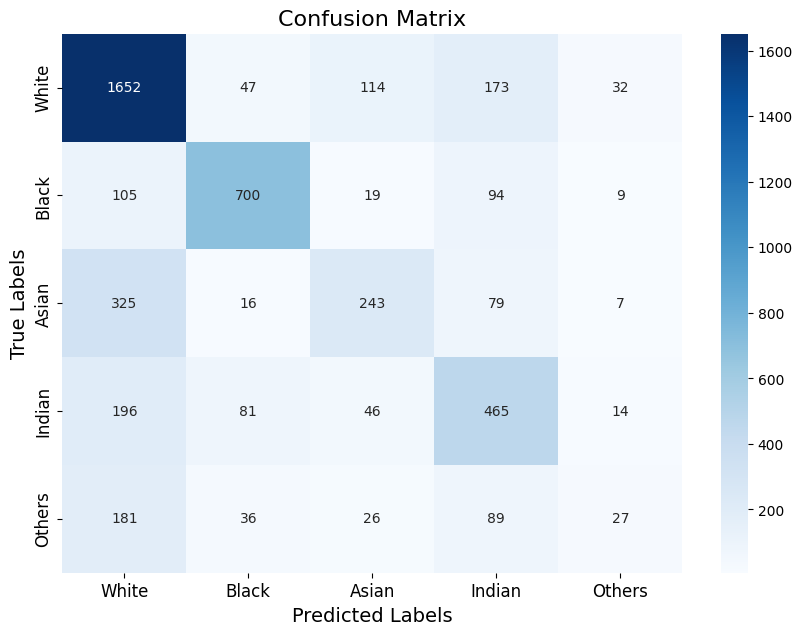


Classification Report:
              precision    recall  f1-score   support

       White       0.67      0.82      0.74      2018
       Black       0.80      0.76      0.77       927
       Asian       0.54      0.36      0.43       670
      Indian       0.52      0.58      0.55       802
      Others       0.30      0.08      0.12       359

    accuracy                           0.65      4776
   macro avg       0.57      0.52      0.52      4776
weighted avg       0.62      0.65      0.62      4776



In [12]:
all_labels = []  # Per memorizzare le etichette reali
all_preds = []   # Per memorizzare le previsioni del modello

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = mouth_net(images)

        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


# Calcola le metriche
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Aggiungi titoli e etichette agli assi
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra la heatmap
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))